Generating a 1000 observation time series dataset with 3 features: temperature, pressure, and vibration. There are 20 anomalies of length 5 that are being injected.

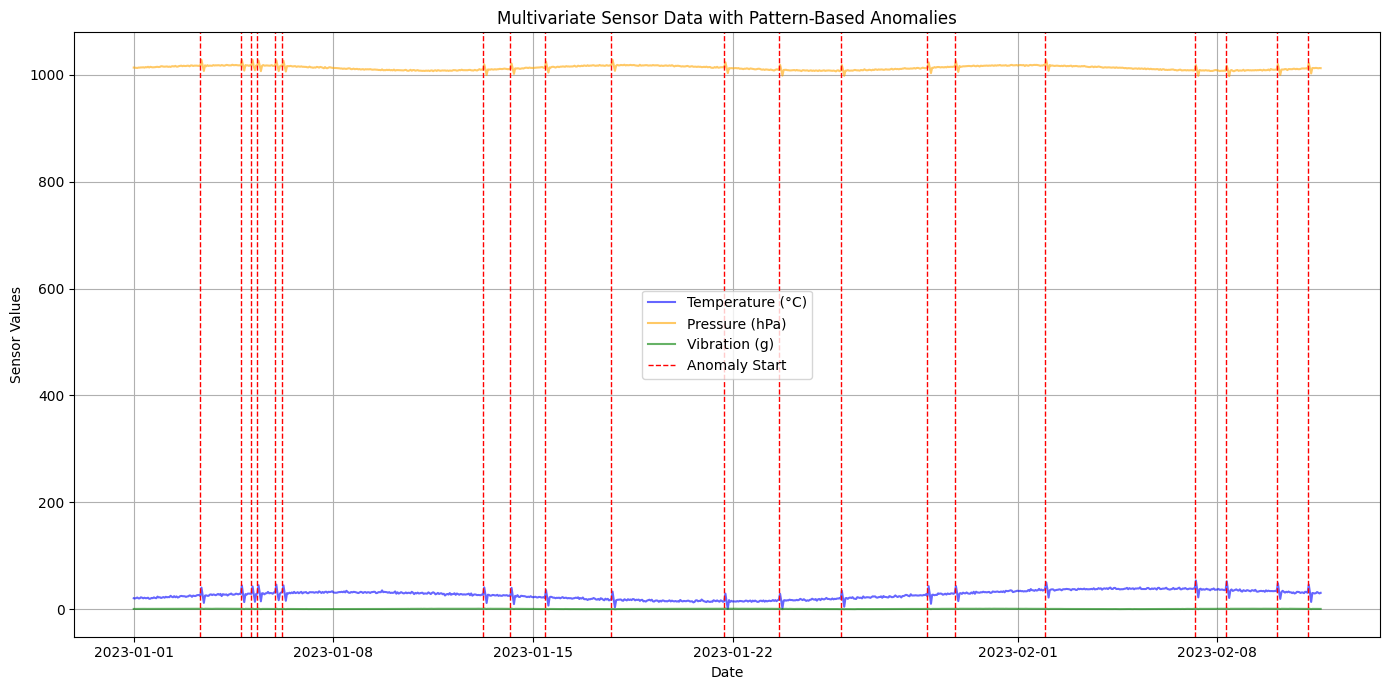

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

np.random.seed(42)

date_rng = pd.date_range(start='2023-01-01', periods=1000, freq='h')
n_records = len(date_rng)
anomaly_pattern_length = 5
n_anomalies = 20

df = pd.DataFrame(date_rng, columns=['date'])

trend = np.linspace(0, 10, n_records)
temperature_pattern = 20 + trend + 10 * np.sin(np.linspace(0, 3 * np.pi, n_records)) + np.random.normal(0, 1, n_records)
pressure_pattern = 1013 + 5 * np.sin(np.linspace(0, 6 * np.pi, n_records)) + np.random.normal(0, 0.5, n_records)
vibration_pattern = 0.5 + 0.3 * np.sin(np.linspace(0, 9 * np.pi, n_records)) + np.random.normal(0, 0.05, n_records)

df['temperature'] = temperature_pattern
df['pressure'] = pressure_pattern
df['vibration'] = vibration_pattern

df['Anomaly'] = 0

anomaly_start_indices = np.random.choice(range(n_records - anomaly_pattern_length), size=n_anomalies, replace=False)

for start_idx in anomaly_start_indices:
    anomaly_temperature_pattern = 15 * np.sin(np.linspace(0, 2 * np.pi, anomaly_pattern_length))
    anomaly_pressure_pattern = 10 * np.sin(np.linspace(0, 2 * np.pi, anomaly_pattern_length))
    anomaly_vibration_pattern = 0.4 * np.sin(np.linspace(0, 2 * np.pi, anomaly_pattern_length))

    df.loc[start_idx:start_idx + anomaly_pattern_length - 1, 'temperature'] += anomaly_temperature_pattern
    df.loc[start_idx:start_idx + anomaly_pattern_length - 1, 'pressure'] += anomaly_pressure_pattern
    df.loc[start_idx:start_idx + anomaly_pattern_length - 1, 'vibration'] += anomaly_vibration_pattern

    df.loc[start_idx:start_idx + anomaly_pattern_length - 1, 'Anomaly'] = 1

plt.figure(figsize=(14, 7))

plt.plot(df['date'], df['temperature'], label='Temperature (°C)', color='blue', alpha=0.6)
plt.plot(df['date'], df['pressure'], label='Pressure (hPa)', color='orange', alpha=0.6)
plt.plot(df['date'], df['vibration'], label='Vibration (g)', color='green', alpha=0.6)

for start_idx in anomaly_start_indices:
    plt.axvline(x=df['date'].iloc[start_idx], color='red', linestyle='--', lw=1, label='Anomaly Start' if start_idx == anomaly_start_indices[0] else "")

plt.title('Multivariate Sensor Data with Pattern-Based Anomalies')
plt.xlabel('Date')
plt.ylabel('Sensor Values')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()


We are doing some feature engineering by scaling the values and also creating sequences so that the LSTM can learn from time series sequences rather than individual values. We are then going to use a simple LSTM architecture.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8803 - loss: 0.6611 - val_accuracy: 0.9375 - val_loss: 0.5281
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8900 - loss: 0.5261 - val_accuracy: 0.9375 - val_loss: 0.2553
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8913 - loss: 0.3876 - val_accuracy: 0.9375 - val_loss: 0.2439
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9011 - loss: 0.3554 - val_accuracy: 0.9375 - val_loss: 0.2443
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8855 - loss: 0.3770 - val_accuracy: 0.9375 - val_loss: 0.2415
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8930 - loss: 0.3629 - val_accuracy: 0.9375 - val_loss: 0.2393
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8901 - loss: 0.3667 - val_accuracy: 0.9375 - val_loss: 0.2376
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8900 - loss: 0.3561 - val_accuracy: 0.9375 - val_loss

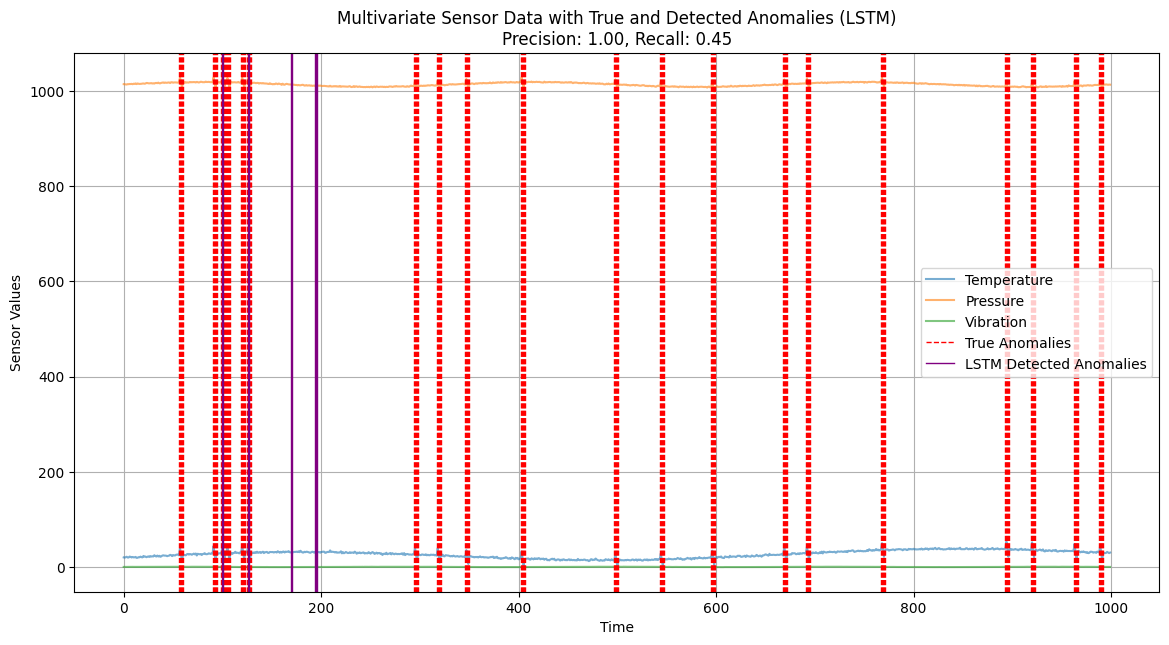

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt


scalers = {}
features = ['temperature', 'pressure', 'vibration']
for feature in features:
    scalers[feature] = MinMaxScaler()
    df[feature] = scalers[feature].fit_transform(df[[feature]])

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

sequence_length = 5

X = create_sequences(df[features].values, seq_length=sequence_length)

y = df['Anomaly'].values[sequence_length - 1: len(df) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], len(features)), return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

df['LSTM_Anomaly'] = 0
anomaly_indices = np.where(y_pred == 1)[0]
for idx in anomaly_indices:
    original_index = df.index[idx + sequence_length - 1]
    df.loc[original_index, 'LSTM_Anomaly'] = 1

plt.figure(figsize=(14, 7))

for feature in features:
    plt.plot(df.index, scalers[feature].inverse_transform(df[[feature]]), label=f'{feature.capitalize()}', alpha=0.6)

for idx in df.index[df['Anomaly'] == 1]:
    plt.axvline(x=idx, color='red', linestyle='--', lw=1, label='True Anomalies' if idx == df.index[df['Anomaly'] == 1][0] else "")

for idx in df.index[df['LSTM_Anomaly'] == 1]:
    plt.axvline(x=idx, color='purple', linestyle='-', lw=1, label='LSTM Detected Anomalies' if idx == df.index[df['LSTM_Anomaly'] == 1][0] else "")

plt.title(f'Multivariate Sensor Data with True and Detected Anomalies (LSTM)\n'
          f'Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.xlabel('Time')
plt.ylabel('Sensor Values')
plt.legend()
plt.grid()
plt.show()
